# Call Center

Resource planning is the bread and butter of any successful business.


Let's take a glimpse into the near future where kalasim has taken up a dominant role in the simulation industry. Hundreds of happy customers are utilizing the support hotline 24/7 from around the globe to obtain professional simulation assistance. Envision a customer service department, where a steady stream of customer requests come in, and the customer service agents are tasked with addressing these inquiries.


![Vintage Gas Pump](callcenter_plantronics.jpg){: .center}

<p align="center">
<i>Call Center (©Plantronics, CC BY-SA 3.0)</i>
</p>

<!-- source https://www.communitechservices.com/no-toggle-single-screen-access -->

Choosing an appropriate shift model and planning shift capacity are key this - and any successful - business operations. Due to the complex dynamics and interplay, it's often very challenging to determine capacity and pinpoint bottlenecks in such systems on paper.

Here is how the envisioned call center functions:

* The requests arrive throughout the day and are queued and pooled, waiting for an available responder.
* The responders are available in two shifts, excluding weekends. Ideally, the two shifts should not have separate queues since there is already a pooled queue.
* If a responder from Shift A is working on a request but is about to end their shift, they will hand over the request they are working on to Shift B.
* Shifts A and B will have different capacities to mimic day/night shift regimes.

Except for weekends, when there are no available shifts, the first available responder the following week will handle the unattended requests.

To get started, let's initialize the environment by loading the latest version of kalasim:

In [ ]:
@file:Repository("*mavenLocal")

%useLatestDescriptors on

@file:DependsOn("com.github.holgerbrandl:kalasim:0.12-SNAPSHOT")
@file:DependsOn("com.github.holgerbrandl:kravis:0.9.95")

In [2]:
import kotlin.math.roundToInt
import kravis.GGPlot
import kravis.SessionPrefs
import kravis.device.SwingPlottingDevice
import org.kalasim.*
import org.kalasim.plot.kravis.display
import java.awt.Desktop
import java.awt.Dimension
import java.nio.file.Files
import java.time.Instant
import kotlin.math.max
import kotlin.time.Duration
import kotlin.time.Duration.Companion.days
import kotlin.time.Duration.Companion.hours
import kotlin.time.Duration.Companion.minutes
import kotlin.time.DurationUnit
import org.kalasim.plot.kravis.display

// Configure kravis for visualization because kernel detection seems buggy in jupyter-lib
kravis.SessionPrefs.OUTPUT_DEVICE = kravis.device.JupyterDevice() // bug in library, 



## Shift System

To engineer a discrete event simulation for this particular business process, we begin by implementing the shift system. Technically, we use a [sequence builder](https://kotlinlang.org/docs/sequences.html) to create a weekly shift sequence that is repeated, allowing the subsequent model to run indefinitely.

In [3]:
enum class ShiftID { A, B, WeekEnd }

val shiftModel = sequence {
    while(true) {
        repeat(5) { yield(ShiftID.A); yield(ShiftID.B) }
        yield(ShiftID.WeekEnd)
    }
}

## Customer Inquiries

Now, we model the customer requests as simulation entities. Each request is modelled as a [`Component`](../component.md) with a dedicated small lifecycle where the call center agent is [request](../component.md#request)ed. The actual process time varies; it is exponentially distributed with an average of around 25 minutes.

In [4]:
class Request : Component() {
    val callCenter = get<Resource>()

    override fun process() = sequence {
        request(callCenter, capacityLimitMode = CapacityLimitMode.SCHEDULE) {
            hold(exponential(25.minutes).sample())
        }
    }
}

##  Shift Manager

Next, we need to model the call center manager to modulate the shift (or in simulation speak [resource](resources.md)) capacity dynamically.

In [5]:
class ShiftManager : Component() {
    val shiftIt = shiftModel.iterator()
    val callCenter = get<Resource>()

    override fun repeatedProcess() = sequence {
        val currentShift = shiftIt.next()

        log("starting new shift ${currentShift}")

        // adjust shift capacity at the beginning of the shift
        callCenter.capacity = when(currentShift) {
            ShiftID.A -> 2.0
            ShiftID.B -> 5.0
            ShiftID.WeekEnd -> 0.0
        }

        // wait for end of shift
        hold(if(currentShift == ShiftID.WeekEnd) 48.hours else 12.hours)
    }
}

## Simulation Environment

Finally, we integrate everything into a simulation [environment](basics.md#simulation-environment) for easy experimentation. To facilitate convenient experimentation with various configurations and decision policies, we maintain the Shift Manager as an abstract entity, obliging the simulator to incorporate a specific implementation to conduct an experiment.

In [6]:
abstract class CallCenter(
    val interArrivalRate: Duration = 10.minutes,
    logEvents: Boolean = false
) :
    Environment(
        enableComponentLogger = logEvents,
        // note tick duration is just needed here to simplify visualization
        tickDurationUnit = DurationUnit.HOURS
    ) {

    // intentionally not defined at this point
    abstract val shiftManager: Component

    val serviceAgents = dependency { Resource("Service Agents") }

    init {
        ComponentGenerator(iat = exponential(interArrivalRate)) { Request() }
    }
}

Let's run the model for a month

In [7]:
val sim = object : CallCenter() {
    override val shiftManager = ShiftManager()
}

sim.run(30.days)

To understand the dynamics of the model, we could now try inpspecting its progression. First we check out the queue length

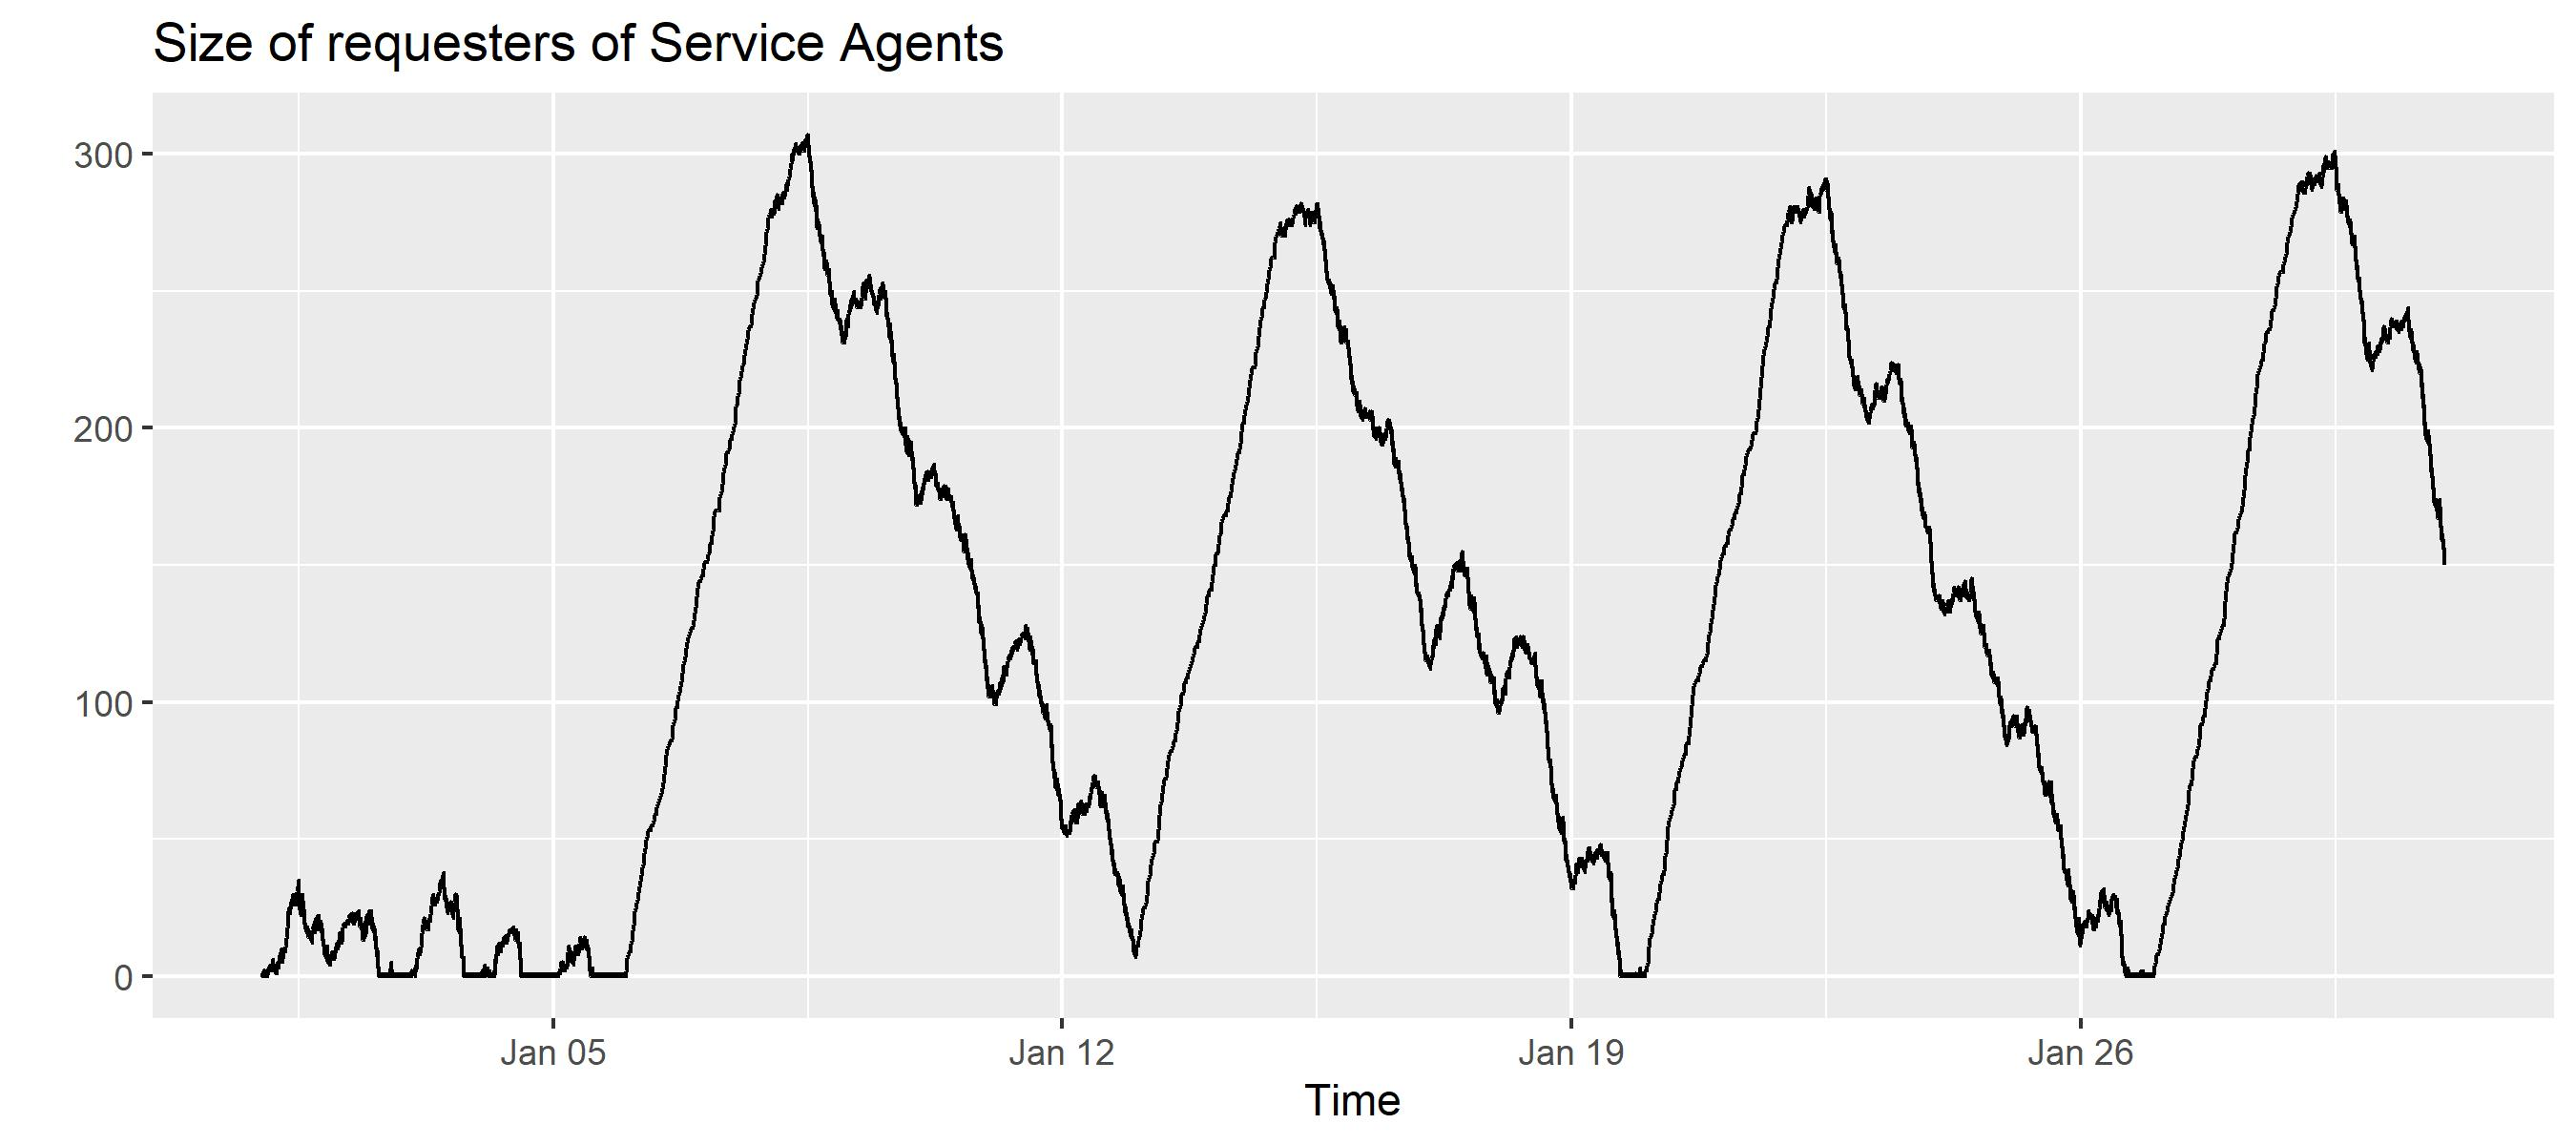

In [8]:
sim.serviceAgents.requesters.queueLengthTimeline.display()


What do we see here? After some warmup in the first week of January, we see requiests piling up over the weekend. These requests are subsequently processed in the next 6 business days. So even if customers may need to wait for a few business days, they are ultimatly served. So from a qeuing theory this system is stable, that is does not end up with an infiinte queue length.
 
## Model Accuracy During Shift Handover 

Clearly, this first version has the limitation that tasks overlapping with a shift-change do not immediately respect changes in capacity. That is, when shifting from a highly-staffed shift to a lesser-staffed shift, ongoing tasks will be completed regardless of the reduced capacity.

It's not straightforward to cancel these tasks and request them again in the next shift. This is because a `release()` will, by design, check if new requests could be served. So, ongoing tasks could be easily released, but re-requesting them - even with higher priority - would lead them to be processed slightly later than the requests that were immediately approved.

To elegantly solve this problem, we can use two other methods - `interrupt()` and `standby()`. With `interrupt()`, we can stop all ongoing tasks at a shift change. With `standby()`, we can schedule process continuation in the next simulation cycle.

For the revised model, we just need to create a different `ShiftManager` with our revised handover process:

In [9]:
class InterruptingShiftManager(
    val aWorkers: Double = 2.0,
    val bWorkers: Double = 5.0
) : Component() {
    val shiftIt = shiftModel.iterator()
    val serviceAgents = get<Resource>()

    override fun repeatedProcess() = sequence {
        val currentShift = shiftIt.next()

        log("starting new shift $currentShift")

        // adjust shift capacity at the beginning of the shift
        serviceAgents.capacity = when(currentShift) {
            ShiftID.A -> aWorkers
            ShiftID.B -> bWorkers
            ShiftID.WeekEnd -> 0.0
        }

        // complete hangover calls from previous shift
        fun shiftLegacy() = serviceAgents.claimers.components
            .filter { it.isInterrupted }

        // incrementally resume interrupted tasks while respecting new capacity
        while(shiftLegacy().isNotEmpty() && serviceAgents.capacity > 0) {
            val numRunning = serviceAgents.claimers.components
                .count { it.isScheduled }
            val spareCapacity = 
                max(0, serviceAgents.capacity.roundToInt() - numRunning)

            // resume interrupted tasks from last shift to max out new capacity
            shiftLegacy().take(spareCapacity).forEach { it.resume() }

            standby()
        }

        // wait for end of shift
        hold(if(currentShift == ShiftID.WeekEnd) 48.hours else 12.hours)

        // stop and reschedule the ongoing tasks
        serviceAgents.claimers.components.forEach {
            // detect remaining task time and request this with high prio so
            // that these tasks are picked up next in the upcoming shift
            it.interrupt()
        }
    }
}

We can now instantiate a new call center with the improved hand-over process

In [10]:
val intSim = object: CallCenter() {
    override val shiftManager = InterruptingShiftManager()
}

// Let's run this model for a month
intSim.run(180.days)

Again we study the request queue length as indicator for system stability:

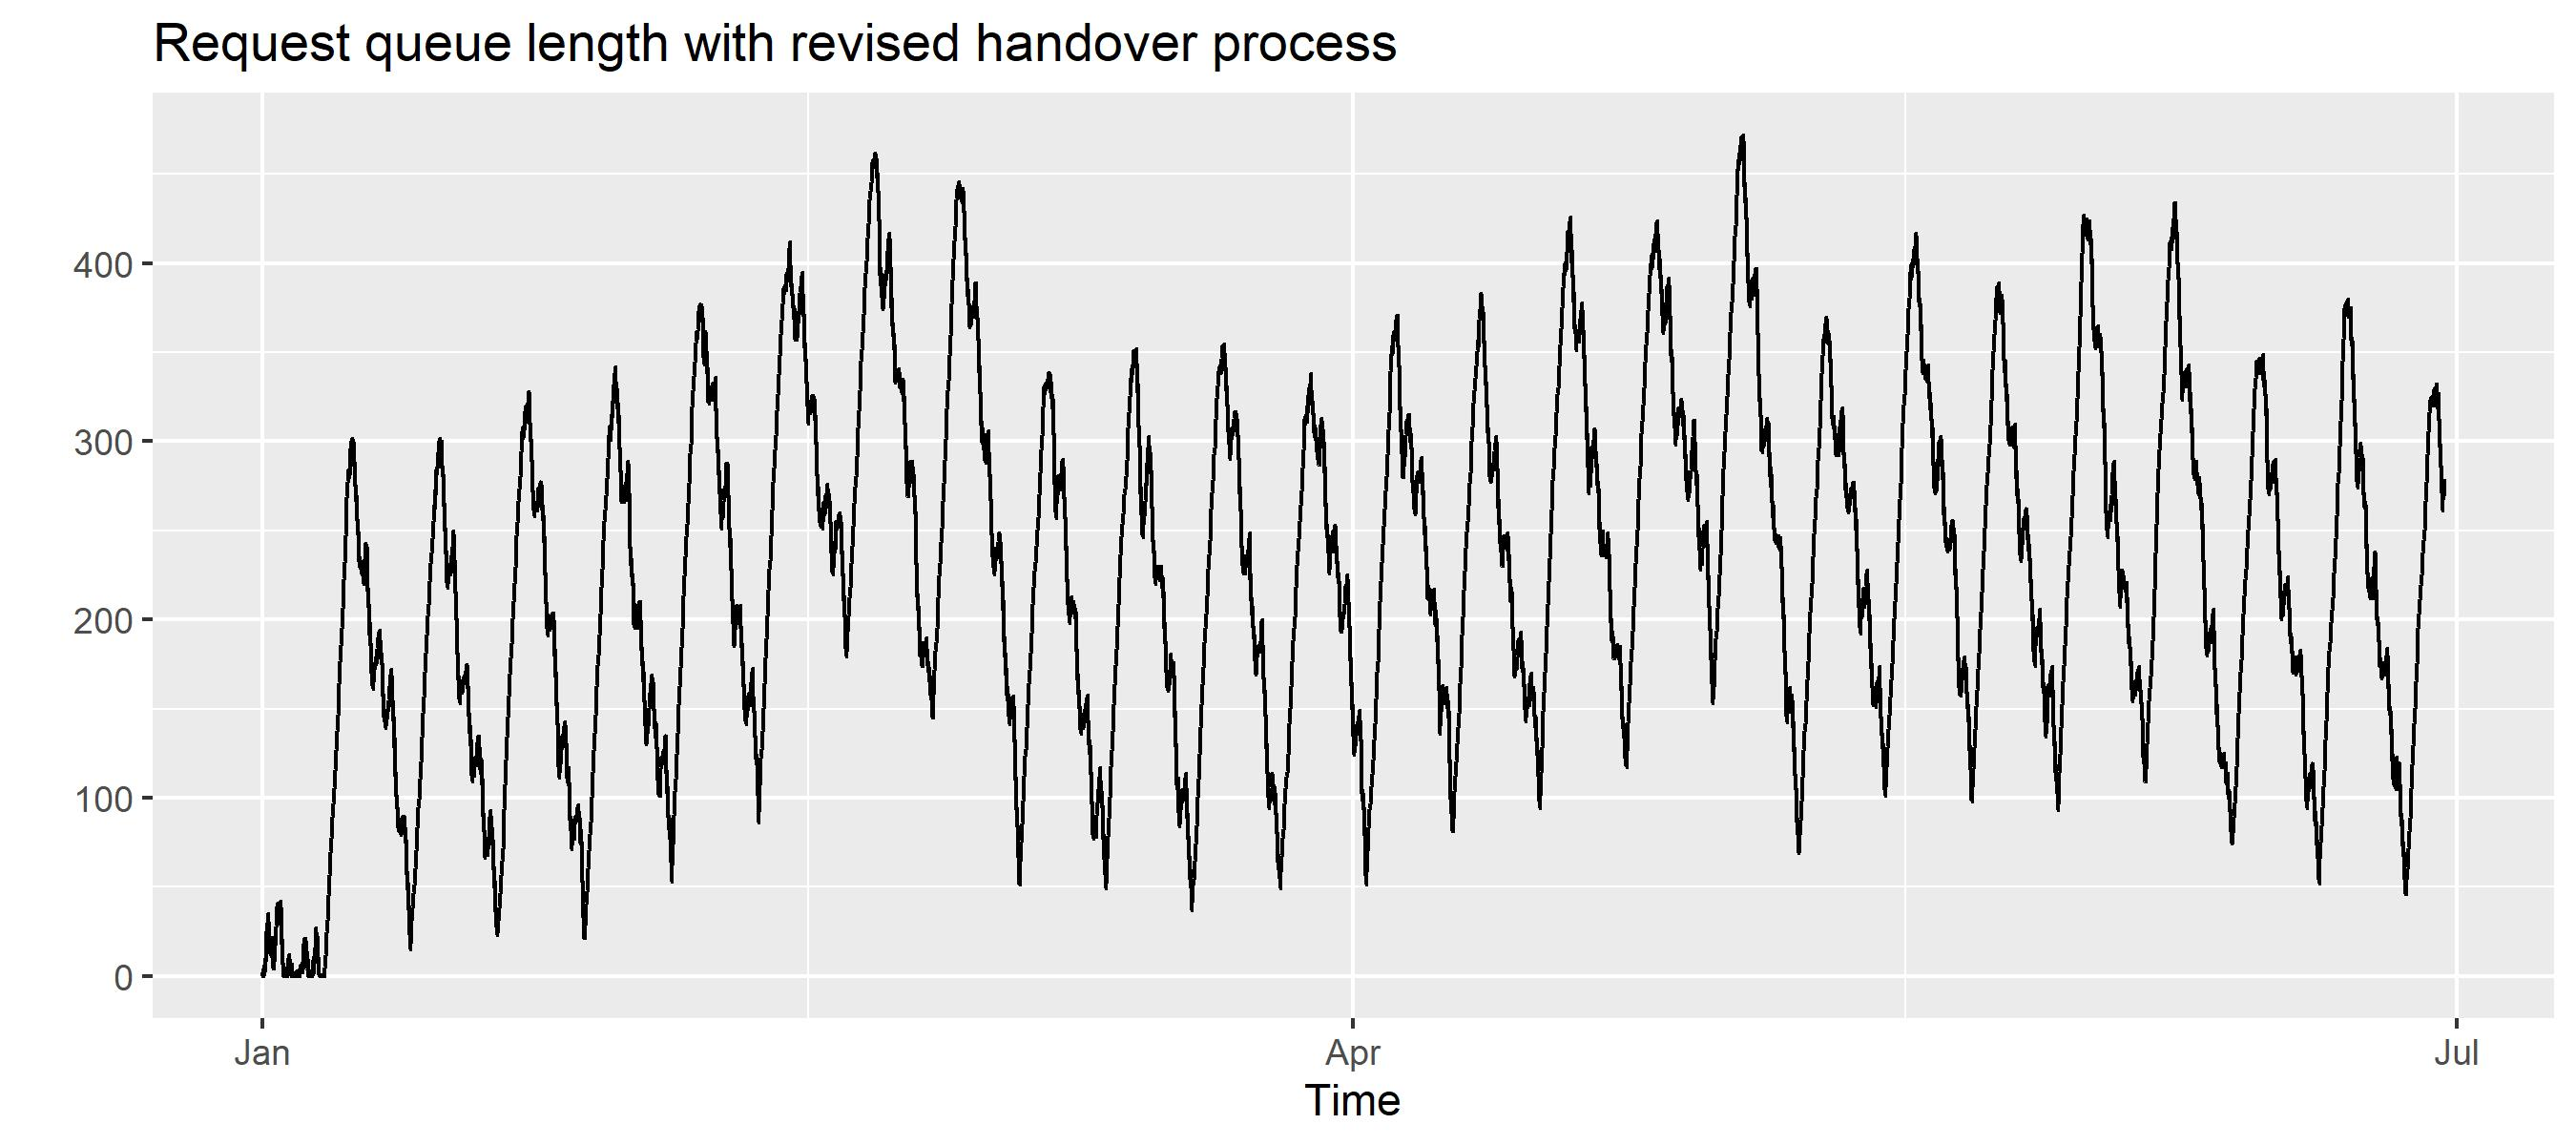

In [11]:
intSim.serviceAgents.requesters.queueLengthTimeline
    .display("Request queue length with revised handover process")


As we can see, the model is not stable. The number of support technicians is not adequate to serve the varying number of customers. Although the request frequency did not change, the more accurate shift transition modeling has impacted the result.

To determine the correct sizing - i.e., the number of service operators needed to reliably serve customers - we will increase the day staff by one support technician and repeat the experiment.

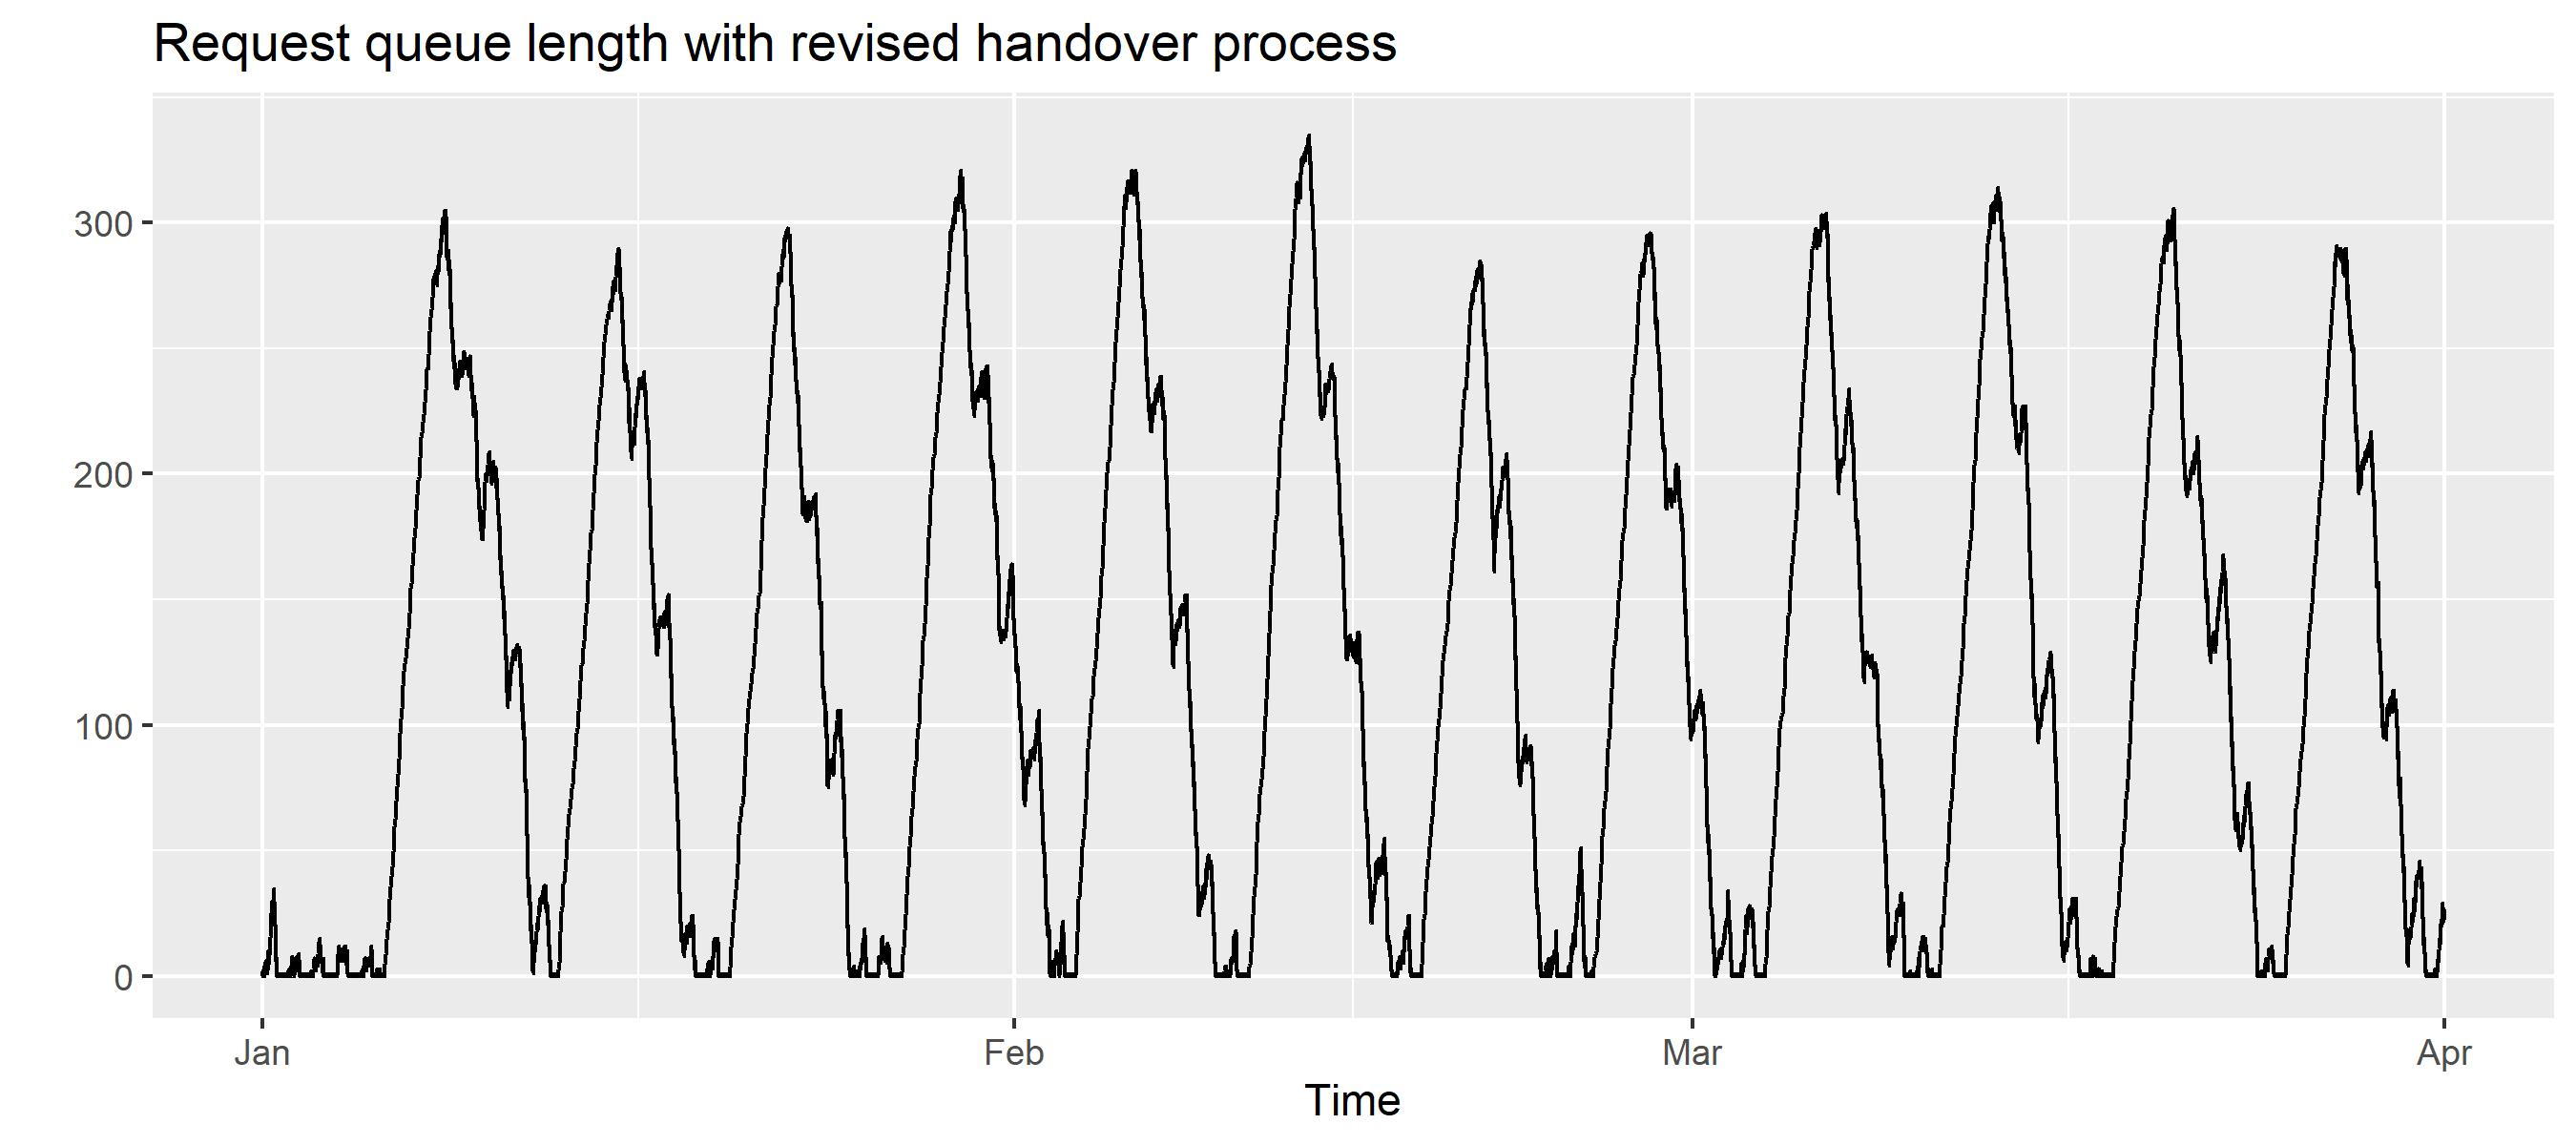

In [12]:
val betterStaffed = object: CallCenter() {
    override val shiftManager = InterruptingShiftManager(bWorkers = 6.0)
}

betterStaffed.run(90.days)


val queueLengthTimeline = betterStaffed.serviceAgents
    .requesters.queueLengthTimeline

queueLengthTimeline.display("Request queue length with revised handover process")

Notably, this model has the almost the same dynamics, but is stable from a queuing perspective.

## Summary

We have successfully modelled a variable shift length schedule and performed a sizing analysis. An initial model indicated that a weekday shift would be sufficiently staffed with 5 workers. However, a more detailed model, which also considers transition effects between shifts, led to the conclusion that 6 support technicians are required to serve the multitude of customers of Future Kalasim Inc.


Could we have solved this more elegantly using the mathematics of queuing theory? Such models are a great starting point, but usually, they very quickly fail to deliver when realistic, non-stationary requirements are considered. That's when discrete event simulation can develop its beauty and potential. Flexible shift schedules are common in many industries, and the model introduced above could be easily adjusted to account for more business constraints and processes.

The  use-case was adopted from the [simmer mailing list](https://groups.google.com/g/simmer-devel/c/gsr6F7CJQf8/m/euW1ZaU0DAAJ)

